# Example data

## Mouse imaging data: dynamic contrast enhanced and oxygen enhanced

To demonstrate the main features and enable benchmarking of different algorithms, we have included a selection of data sets ([download here](https://doi.org/10.17863/CAM.93181)) with PATATO that were collected using a cylindrical-array pre-clinical (small animal) PAI system and a handheld clinical PAI system (MSOT inVision 256 and MSOT Acuity Echo respectively; both iThera Medical GmbH, Munich, Germany). Animal procedures were conducted under project licence PE12C2B96 and personal licence I33984279, issued under the United Kingdom Animals (Scientific Procedures) Act, 1986, and were approved locally under compliance form number CFSB2022. Detailed methods for this procedure have been published previously ([Tomaszewski 2018](https://doi.org/10.1158/0008-5472.CAN-18-1033)).


The typical photoacoustic analysis procedure in PATATO can be illustrated using the mouse dataset described above. In this study, mice were implanted with tumours and photoacoustic images were acquired to interrogate the blood perfusion of the tumours. We perturbed the distribution of absorbing molecules in the mouse by changing the breathing gas to oxygen, thereby causing a change in the blood oxygenation, and by injecting the contrast agent indocyanine green (ICG). PATATO allows the streamlined analysis of such datasets (see figure below). Firstly, we reconstructed the photoacoustic images by backprojection. We then drew polygon regions of interest around three regions of the mouse: the two implanted tumours and the spine (see figure A below). To obtain maps of the blood oxygenation ($sO_2$), total haemoglobin (THb), and ICG content we applied linear spectral unmixing (see figure B below). Plots of the $sO_2$ and $ICG$ levels in the three regions over time were made and the enhancement level was calculated (see figure C below). Maps of the signal enhancement ($\Delta sO_2$ or $\Delta ICG$) were then made, revealing useful biomarkers related to hypoxia and blood perfusion respectively.

The dataset is summarised in the figure below, the key components of which can be generated as follows.

![Overall figure showing the oxygen enhanced imaging and dynamic contrast enhanced analysis procedure.](../../paper/jossfig3.png)

In [1]:
import patato as pat
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Change the folder here
data_folder = Path("dataset")

pa_so2 = pat.PAData.from_hdf5(data_folder / "invivo_oe.hdf5")
pa_icg = pat.PAData.from_hdf5(data_folder / "invivo_dce.hdf5")
pa_icg.external_roi_interface = pa_so2

reconstruction = pa_so2.get_scan_reconstructions()[("Reference Backprojection", "0")]
so2 = pa_so2.get_scan_so2()[("Reference Backprojection", "0")]

pa_icg_unmixed = pa_icg.get_scan_unmixed()[("Reference Backprojection", "0ICG")]
icg = pa_icg_unmixed[:, 2]
# ICG is the third element of the unmixed array.

# ROIs were drawn using `patato-draw-roi` are were saved in the HDF5 file.
roi_tumour_right = pa_so2.get_rois()["tumour_right", "0"]
roi_tumour_left = pa_so2.get_rois()["tumour_left", "0"]
roi_reference = pa_so2.get_rois()["reference_", "0"]

# Time axis:
time_so2 = pa_so2.get_timestamps()[:, 0]
time_so2 -= time_so2[0]

time_icg = pa_icg.get_timestamps()[:, 0]
time_icg -= time_icg[0]

We will start by getting a binary mask representing the ROI, then apply it to the $sO_2$ data.

In [3]:
tumour_right_mask, _ = roi_tumour_right.to_mask_slice(so2)
tumour_left_mask, _ = roi_tumour_left.to_mask_slice(so2)
reference_mask, _ = roi_reference.to_mask_slice(so2)

# Apply the masks to the sO2 time series.
so2_time_series_tumour_right = np.mean(so2.raw_data.T[tumour_right_mask.T].T, axis=-1)
so2_time_series_tumour_left = np.mean(so2.raw_data.T[tumour_left_mask.T].T, axis=-1)
so2_time_series_reference = np.mean(so2.raw_data.T[reference_mask.T].T, axis=-1)

icg_time_series_tumour_right = np.mean(icg.raw_data.T[tumour_right_mask.T].T, axis=-1)
icg_time_series_tumour_left = np.mean(icg.raw_data.T[tumour_left_mask.T].T, axis=-1)
icg_time_series_reference = np.mean(icg.raw_data.T[reference_mask.T].T, axis=-1)

Now we can make a plot of how the blood oxygenation in the mouse regions varies over time.

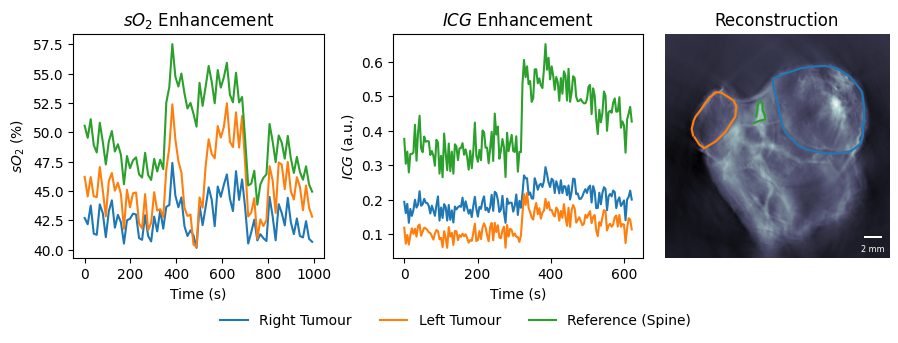

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
# Plot the so2 time series.
ax1.plot(time_so2, so2_time_series_tumour_right * 100, label="Right Tumour")
ax1.plot(time_so2, so2_time_series_tumour_left * 100, label="Left Tumour")
ax1.plot(time_so2, so2_time_series_reference * 100, label="Reference (Spine)")

# PLot the icg time series.
ax2.plot(time_icg, icg_time_series_tumour_right, label="Right Tumour")
ax2.plot(time_icg, icg_time_series_tumour_left, label="Left Tumour")
ax2.plot(time_icg, icg_time_series_reference, label="Reference (Spine)")

# Show the reconstruction and plot the roi over the top
reconstruction.imshow(ax=ax3, cmap="bone")
ax3.plot(roi_tumour_right.points[:, 0], roi_tumour_right.points[:, 1], "C0")
ax3.plot(roi_tumour_left.points[:, 0], roi_tumour_left.points[:, 1], "C1")
ax3.plot(roi_reference.points[:, 0], roi_reference.points[:, 1], "C2")

ax1.set_title("$sO_2$ Enhancement")
ax2.set_title("$ICG$ Enhancement")
ax3.set_title("Reconstruction")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("$sO_2$ (%)")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("$ICG$ (a.u.)")

fig.legend(*ax1.get_legend_handles_labels(), frameon=False, ncol=3, loc="center",
           bbox_to_anchor=(0.5, -0.05))
plt.show()

The signal enhancement levels can be calculated as follows. This is calculated as the difference between the baseline and the signal after injection of the contrast agent or after the breathing gas is changed.

In [5]:
oxygen_enhancement_analyser = pat.GasChallengeAnalyser(display_output=False)
delta_so2, _, (baseline_so2, baseline_so2_sigma) = oxygen_enhancement_analyser.run(so2, pa_so2)

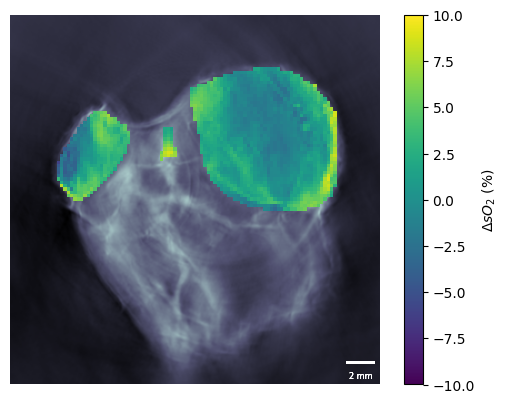

In [6]:
reconstruction.imshow()
delta_so2.raw_data *= 100 # Convert to percentage points
delta_so2.imshow(clim=(-10, 10), roi_mask=roi_tumour_left)
delta_so2.imshow(clim=(-10, 10), roi_mask=roi_tumour_right)
im = delta_so2.imshow(clim=(-10, 10), roi_mask=roi_reference)
plt.colorbar(im, label=r"$\Delta sO_2$ (%)")
plt.show()

In [7]:
icg_enhancement_analyser = pat.DCEAnalyser(display_output=False)
delta_icg, _, (baseline_icg, baseline_icg_sigma) = icg_enhancement_analyser.run(pa_icg_unmixed, pa_icg)

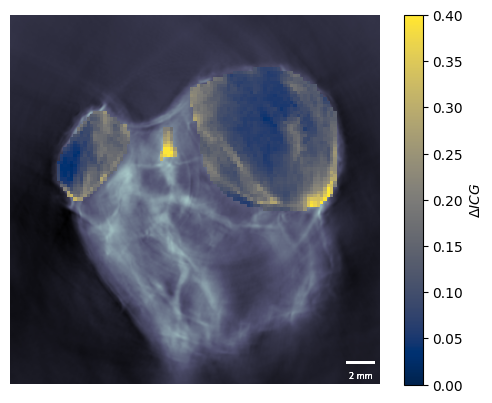

In [8]:
reconstruction.imshow()
delta_icg.imshow(clim=(0, 0.4), roi_mask=roi_tumour_left)
delta_icg.imshow(clim=(0, 0.4), roi_mask=roi_tumour_right)
im = delta_icg.imshow(clim=(0, 0.4), roi_mask=roi_reference)
plt.colorbar(im, label=r"$\Delta ICG$")
plt.show()

Take a look at the example scripts to learn more about the analysis procedure.